<a href="https://colab.research.google.com/github/Allessyer/Piano-Notes-Preprocessing/blob/main/Final_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import canny
from scipy import ndimage as ndi

## Functions

In [ ]:
def show(x,size=10):
    plt.figure(figsize=(size, size))
    plt.imshow(x, cmap='gray')
    plt.axis('off')

def colorspace(img_orig,space,components=False):
    if space == 'rgb':
        img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    elif space == 'gray':
        img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    elif space == 'hls':
        img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2HLS)    
    elif space == 'hsv':
        img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2HSV)
    elif space == 'yuv':
        img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2YUV)
    elif space == 'lab':
        img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2LAB)
        
    if components == True:
        return img[:, :, 0],img[:, :, 1],img[:, :, 2] 
    else:
        return img
    
def inverse_image(image):
    image = cv2.bitwise_not(image)
    return image

In [ ]:
def find_notes(image):
    image_gray = colorspace(image,'gray')
    image_gray = image_gray.astype(np.uint8)
    kernel = np.ones((10,10))
    mask = cv2.morphologyEx(image_gray, cv2.MORPH_CLOSE, kernel)

    mask = mask>120
    mask = mask.astype(np.uint8)
    
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    image[np.sum(mask == [0,0,0], axis=2) ==3] = [0,255,0]
    
    return image

In [ ]:
def remove_notes(image):
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image_gray = colorspace(image,'gray')
    image_gray[np.where(image_gray != 255)] = 0
    
    contours, hierarchy = cv2.findContours(image_gray,  cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for  cnt in contours]
    max_area_1 = sorted(areas,reverse=True)[0]
    max_area_2 = sorted(areas,reverse=True)[1]
    
    contours_best = [cnt for  cnt in contours[1:] if (cv2.contourArea(cnt) > (max_area_2 // 2)) and (cv2.contourArea(cnt) <max_area_1)]
    image = cv2.drawContours(image, contours_best, -1, (255,0,0), -1)
    # show(image,size=20)
    mask = image.copy()
    image[np.sum(image == [255,0,0], axis=2) ==3] = [255,255,255]
    
    return image,mask

In [ ]:
def find_big_triangles(train_bgr, mask):
    
    key_points = []
    key_points_real = []
    lables = []
    
    gray = colorspace(train_bgr, 'gray')
    ret,temp = cv2.threshold(gray,200,255,cv2.THRESH_BINARY_INV)
    contours_2,hierarchy = cv2.findContours(temp,2,1)

    contours,hierarchy = cv2.findContours(temp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    canvas = np.zeros((temp.shape[0],temp.shape[1],3), np.uint8)


    for i in range(len(contours)):
        cnt = contours[i]
        max_area = cv2.contourArea(cnt)

        perimeter = cv2.arcLength(cnt,True)
        epsilon = 0.01*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)

        hull = cv2.convexHull(cnt)

        if len(approx) == 4:
            
            key_points.append(approx)
            
            if abs(key_points[-1][0][0][0] - key_points[-1][2][0][0]) <= 5 and abs(key_points[-1][1][0][1] - key_points[-1][3][0][1]) <= 5 and key_points[-1][0][0][0] > key_points[-1][1][0][0]:

                cv2.drawContours(canvas, cnt, -1, (255, 0, 0), 3)
                cv2.drawContours(canvas, approx, -1, (0, 0, 255), 5)
                lables.append('+')
                key_points_real.append(key_points[-1])
                
            elif abs(key_points[-1][0][0][0] - key_points[-1][2][0][0]) <= 5 and abs(key_points[-1][1][0][1] - key_points[-1][3][0][1]) <= 5 and key_points[-1][0][0][0] < key_points[-1][1][0][0]:
                cv2.drawContours(canvas, cnt, -1, (0, 255, 0), 3)
                cv2.drawContours(canvas, approx, -1, (0, 0, 255), 5)
                lables.append('-')
                key_points_real.append(key_points[-1])
            
    return canvas, key_points_real, lables

In [ ]:
def new_label_masks(key_points, lables,mask):
    for i in range(len(key_points)):
        start = 0
        for k in range(min(key_points[i][1][0][1], key_points[i][3][0][1]), 0, -1):
            if sum(mask[k, min(key_points[i][1][0][0], key_points[i][3][0][0]), :] == [255,0,0]) == 3:
                start += 1
                if sum(mask[k-1, min(key_points[i][1][0][0], key_points[i][3][0][0]), :] == [255,255,255]) == 3:
                    if start > 50:
                        current_1 = k
                        break

        
        if lables[i] == '+':
            mask[current_1-70:max(key_points[i][0][0][1], key_points[i][2][0][1], key_points[i][1][0][1], key_points[i][3][0][1])+5, 
                 min(key_points[i][0][0][0], key_points[i][1][0][0], key_points[i][2][0][0], key_points[i][3][0][0])-5:
                 max(key_points[i][0][0][0], key_points[i][1][0][0], key_points[i][2][0][0], key_points[i][3][0][0])+5, :] = [0,255,0]
        
        else:
            mask[current_1-70:max(key_points[i][0][0][1], key_points[i][2][0][1], key_points[i][1][0][1], key_points[i][3][0][1])+5, 
                 min(key_points[i][0][0][0], key_points[i][1][0][0], key_points[i][2][0][0], key_points[i][3][0][0])-5:
                 max(key_points[i][0][0][0], key_points[i][1][0][0], key_points[i][2][0][0], key_points[i][3][0][0])+5, :] = [0,0,255]
            
    return mask 

In [ ]:
def notes_classification(notes, new_mask):
    notes_plus = notes.copy()
    notes_plus[np.sum(new_mask == [0,255,0],axis=2) != 3] = [255,255,255]

    notes_minus = notes.copy()
    notes_minus[np.sum(new_mask == [0,0,255],axis=2) != 3] = [255,255,255]
    
    return notes_plus, notes_minus

In [ ]:
def gradient_for_plus(new_mask, notes_plus, notes):
    
    notes_hsv = cv2.cvtColor(notes, cv2.COLOR_RGB2HSV)
    green_rect = new_mask.copy()
    green_rect[np.sum(green_rect == [0,255,0],axis=2) != 3] = [0,0,0]
    green_rect[np.sum(green_rect == [0,255,0],axis=2) == 3] = [255,255,255]

    cnt, _ = cv2.findContours(green_rect[:,:,0], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    notes_plus_hsv = cv2.cvtColor(notes_plus, cv2.COLOR_RGB2HSV)
    indexes = np.where(np.sum(notes_plus_hsv == [60,255,255], axis=2) == 3)
    indexes_array = np.array(indexes)

    for c in range(len(cnt)):

        lef_border = cnt[c][0][0][1] < indexes_array[0]
        right_border = indexes_array[0] < cnt[c][1][0][1]
        top_border = cnt[c][0][0][0] < indexes_array[1]
        bottom_border = indexes_array[1] < cnt[c][2][0][0]

        work_area = (lef_border*1 + right_border*1 + top_border*1 + bottom_border*1)

        real_ind = []
        real_ind.append([indexes_array[0][work_area == 4],indexes_array[1][work_area == 4]])
        real_ind = np.array(real_ind)
        indexes_sort = real_ind[0][ :, real_ind[0][1].argsort()]

        for  i in range(len(indexes_sort[0])):
            colors = np.linspace(60, 0, len(indexes_sort[0]))
            notes_hsv[indexes_sort[0],indexes_sort[1],0] = np.uint8(colors)
            notes_hsv[indexes_sort[0],indexes_sort[1],1] = 150
            
    
    plus_gradient_rbg = cv2.cvtColor(notes_hsv, cv2.COLOR_HSV2RGB)
    return plus_gradient_rbg

In [ ]:
def gradient_for_minus(new_mask, notes_minus, notes):
    notes_hsv = cv2.cvtColor(notes, cv2.COLOR_RGB2HSV)
    blue_rect = new_mask.copy()
    blue_rect[np.sum(blue_rect == [0,0,255],axis=2) != 3] = [0,0,0]
    blue_rect[np.sum(blue_rect == [0,0,255],axis=2) == 3] = [255,255,255]

    cnt, _ = cv2.findContours(blue_rect[:,:,0], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    notes_minus_hsv = cv2.cvtColor(notes_minus, cv2.COLOR_RGB2HSV)
    indexes = np.where(np.sum(notes_minus_hsv == [60,255,255], axis=2) == 3)
    indexes_array = np.array(indexes)

    for c in range(len(cnt)):

        lef_border = cnt[c][0][0][1] < indexes_array[0]
        right_border = indexes_array[0] < cnt[c][1][0][1]
        top_border = cnt[c][0][0][0] < indexes_array[1]
        bottom_border = indexes_array[1] < cnt[c][2][0][0]

        work_area = (lef_border*1 + right_border*1 + top_border*1 + bottom_border*1)

        real_ind = []
        real_ind.append([indexes_array[0][work_area == 4],indexes_array[1][work_area == 4]])
        real_ind = np.array(real_ind)
        indexes_sort = real_ind[0][ :, real_ind[0][1].argsort()]

        for  i in range(len(indexes_sort[0])):
            colors = np.linspace(60, 120, len(indexes_sort[0]))
            notes_hsv[indexes_sort[0],indexes_sort[1],0] = np.uint8(colors)
            notes_hsv[indexes_sort[0],indexes_sort[1],1] = 150

 
    notes_hsv[np.sum(notes_hsv == [60,255,255], axis=2) == 3] = [60,150,255]

    return cv2.cvtColor(notes_hsv, cv2.COLOR_HSV2RGB)

In [ ]:
def color_notes(image):
    
    notes = find_notes(image)
    image, mask = remove_notes(image)
    result_img, key_points, lables  = find_big_triangles(image, mask)
    new_mask = new_label_masks(key_points, lables,mask)
    notes_plus, notes_minus = notes_classification(notes, new_mask)
    notes = gradient_for_plus(new_mask, notes_plus, notes)
    result = gradient_for_minus(new_mask, notes_minus, notes)
    
    return result

## Solution

In [ ]:
trains = ['dataset/train/train_1.png','dataset/train/train_2.png','dataset/train/train_3.png']
tests = ['dataset/test/test_1.png','dataset/test/test_2.png','dataset/test/test_3.png','dataset/test/test_4.png','dataset/test/test_5.png','dataset/test/test_6.png']

### on train dataset

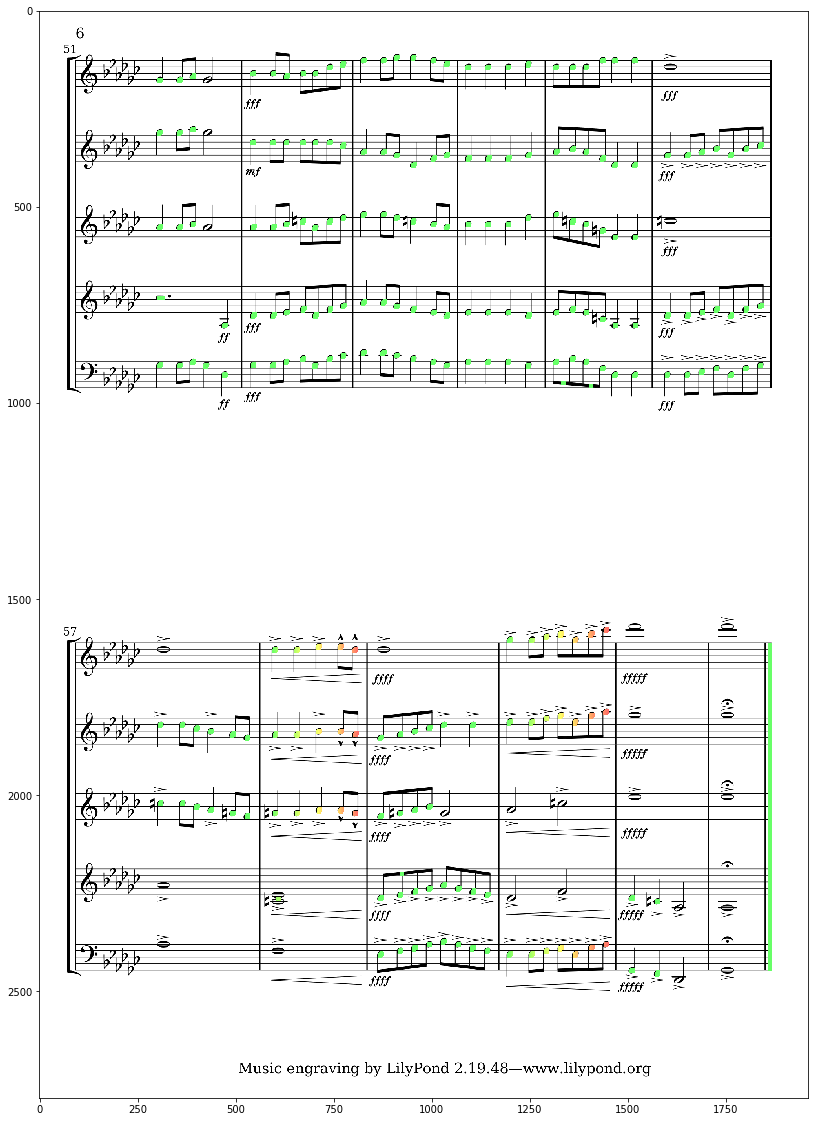

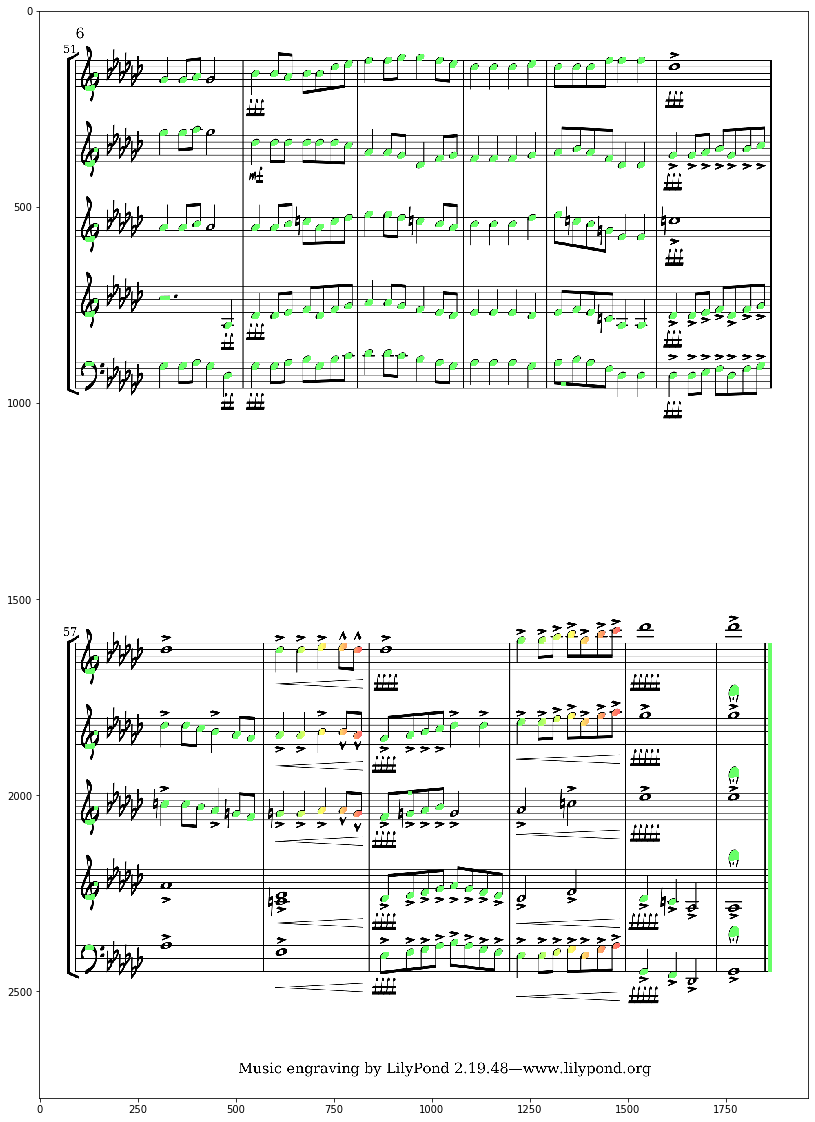

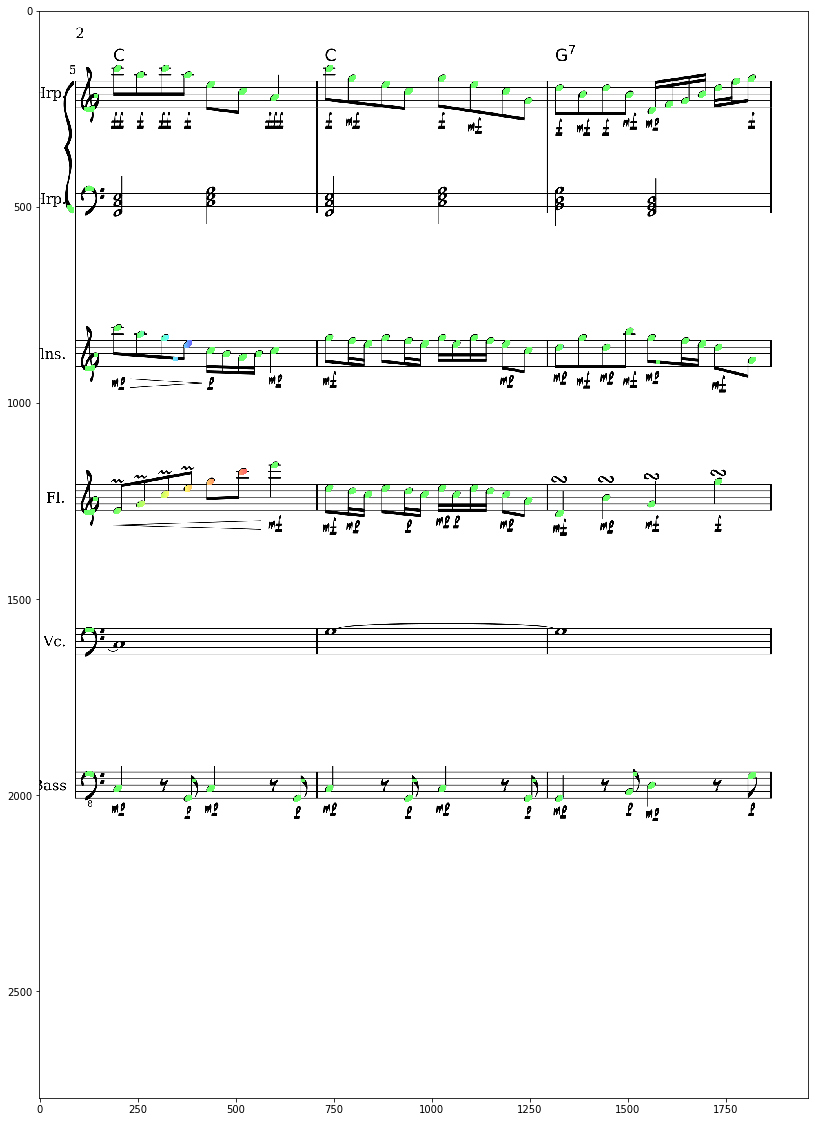

In [ ]:
for i in range(len(trains)):
    train_bgr = cv2.imread(trains[i])
    train_bgr = color_notes(train_bgr)
    plt.figure(figsize=(20,20))
    plt.imshow(train_bgr)
    plt.show()

### on test dataset

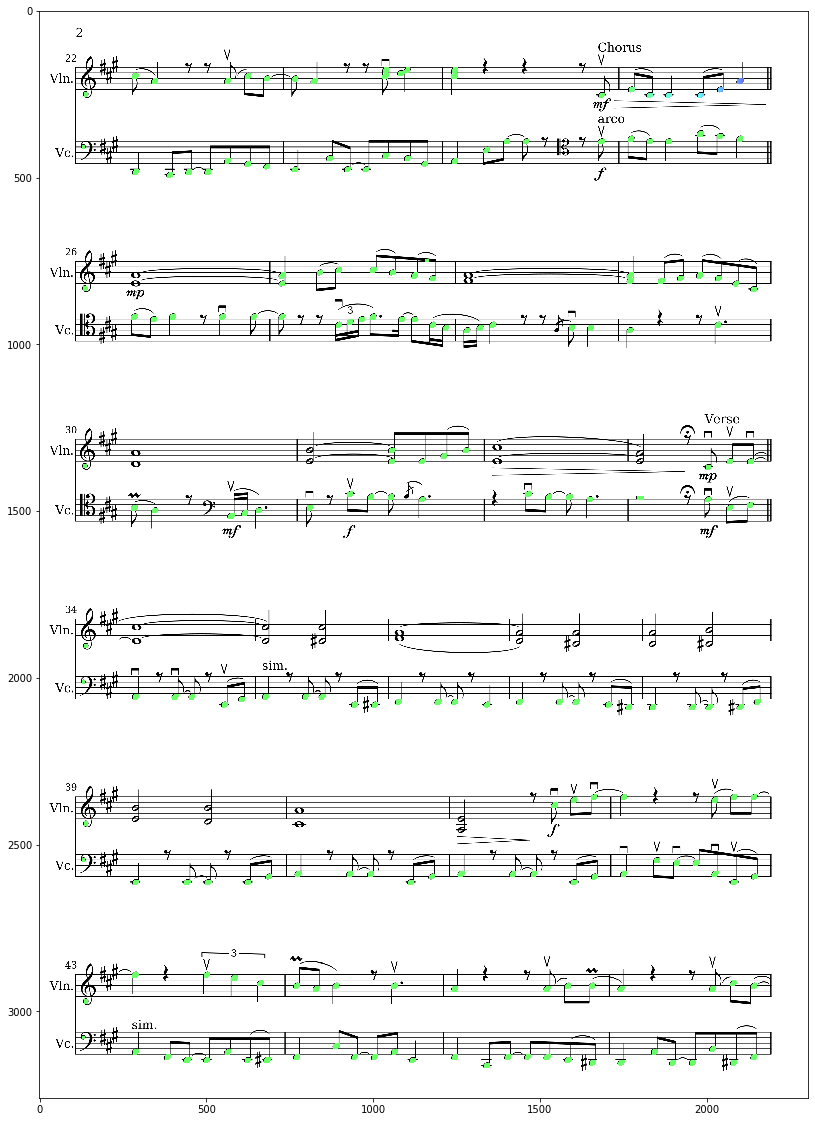

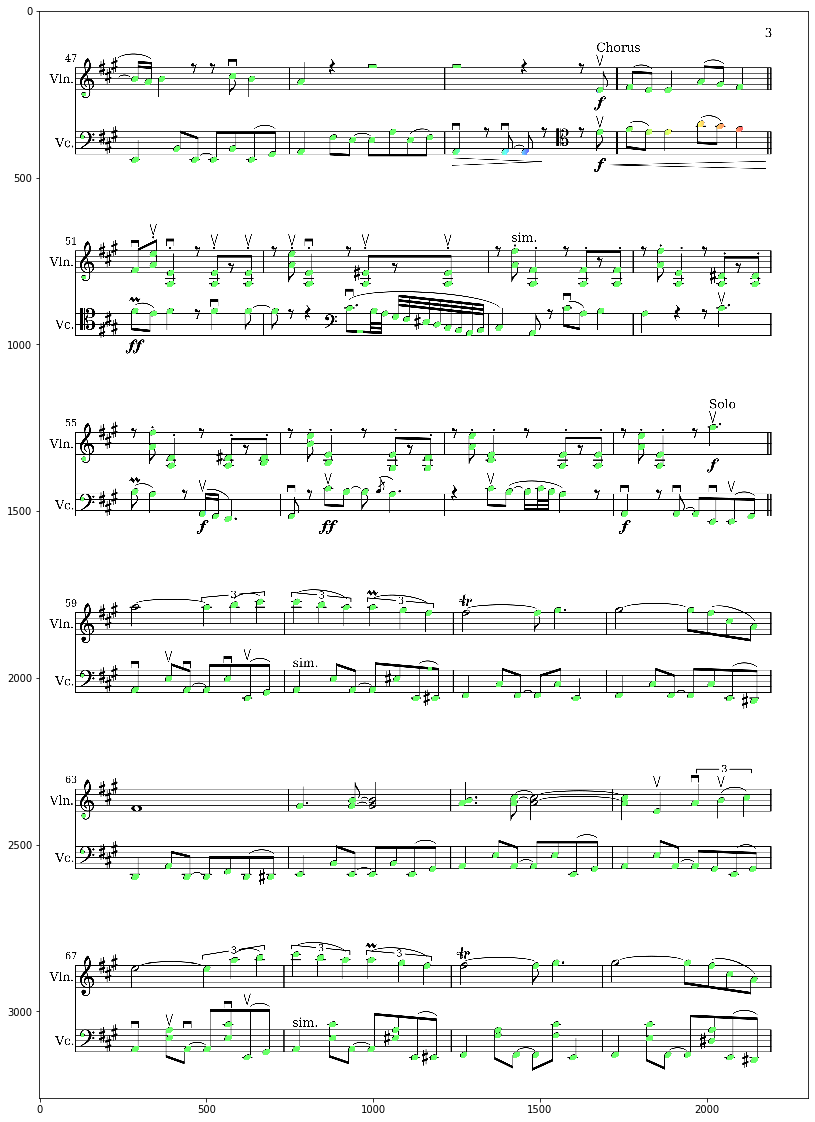

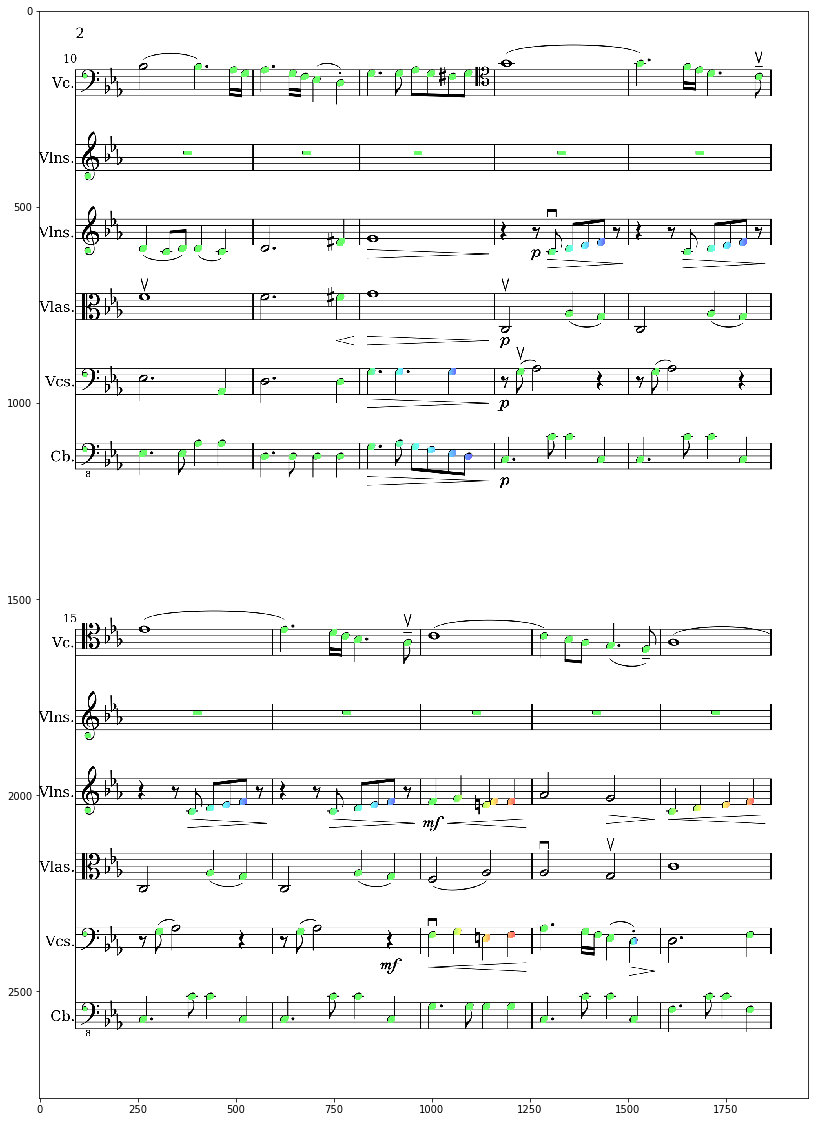

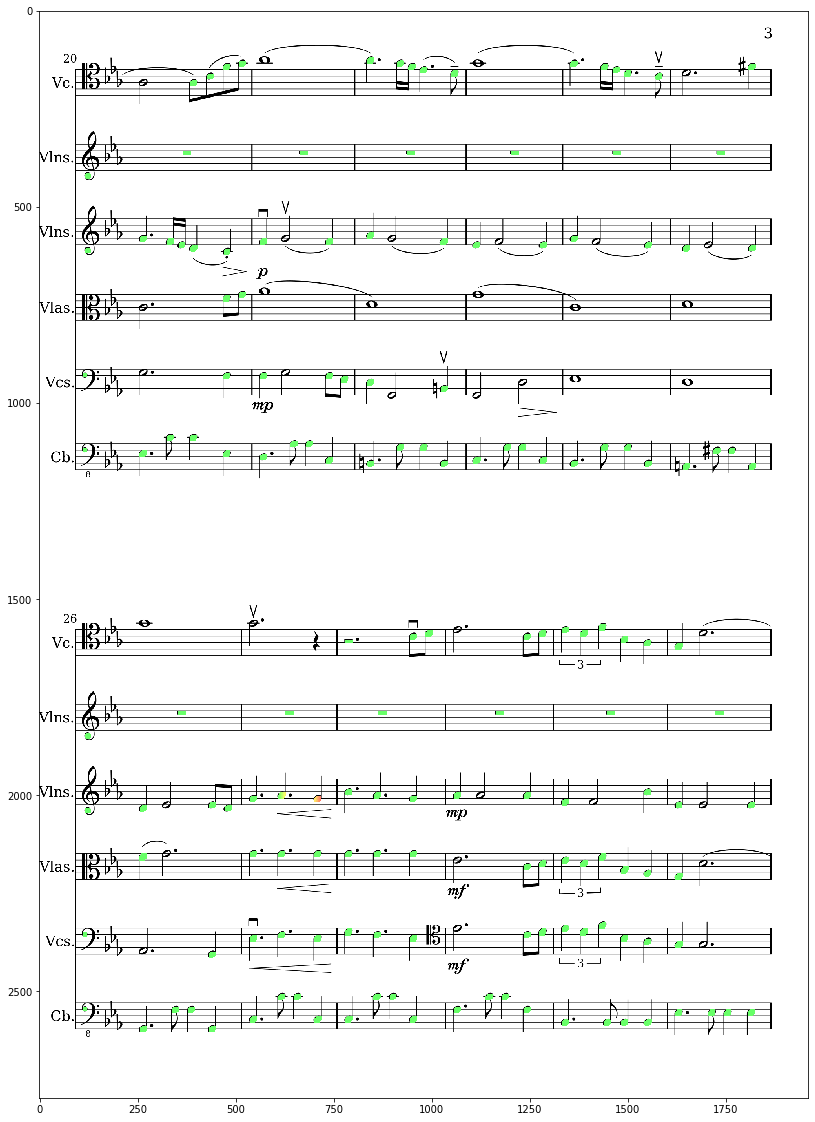

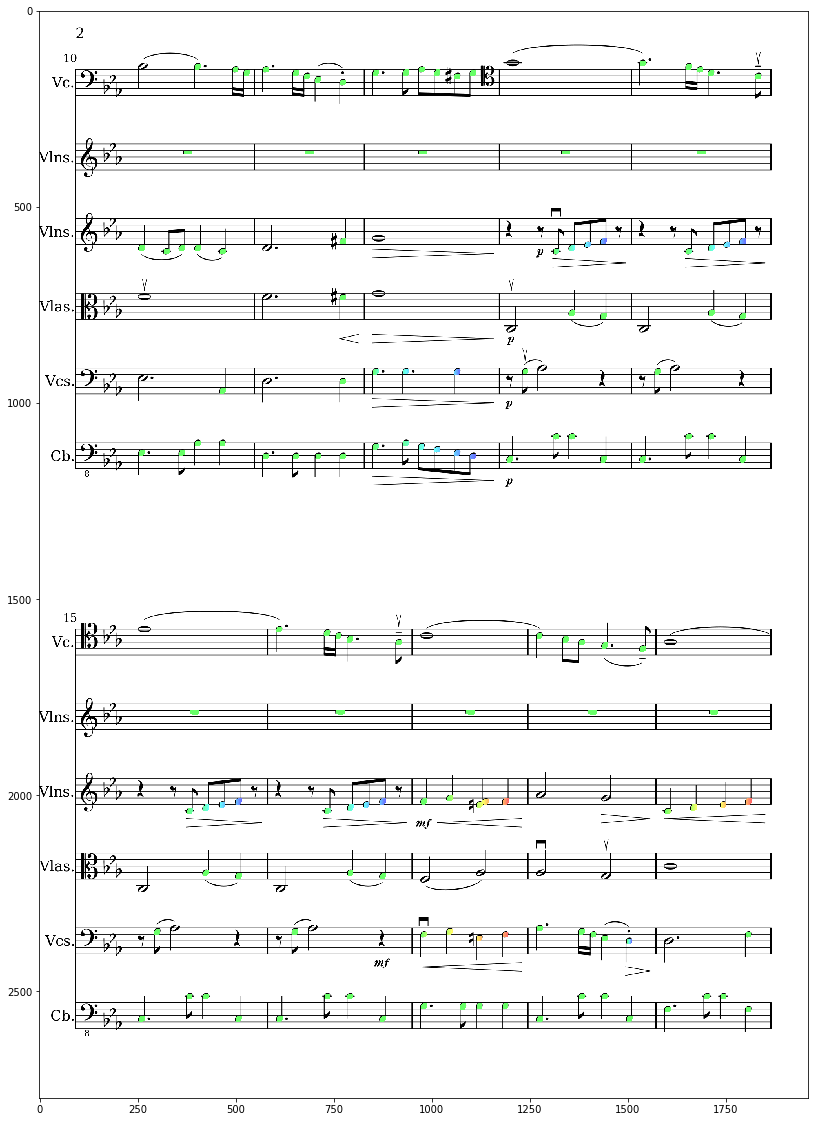

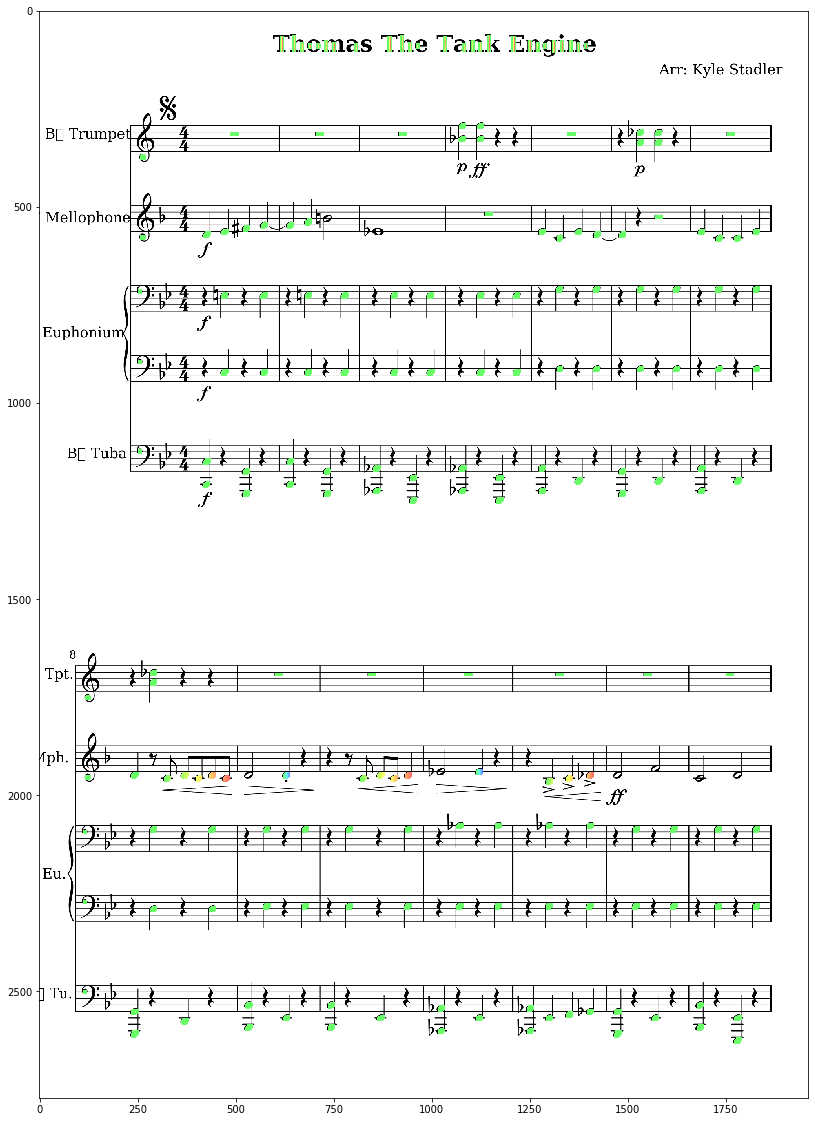

In [ ]:
for i in range(len(tests)):
    train_bgr = cv2.imread(tests[i])
    train_bgr = color_notes(train_bgr)
    plt.figure(figsize=(20,20))
    plt.imshow(train_bgr)
    plt.show()